# Градиентный бустинг и тюнинг моделей

В данном задании необходимо:
1. Реализовать модель с использованием библиотеки `CatBoost`
2. Разделить данные на обучающую, валидационную и тестовую выборки
    * Предобработать данные, переведя молекулярную структуру в численные признаки
3. Провести перебор гиперпараметров модели
4. Оценить качество на тестовой выборке с помощью `ROG_AUC` и `Accuracy`
5. Визуализировать важность признаков
6. Сделать выводы

Начнём по порядку.

## Считывание и предобработка данных

Для начала импортируем датасет из библиотеки `PyTDC`:

In [1]:
import numpy as np
import pandas as pd

In [62]:
from tdc.single_pred import ADME

data = ADME(name='CYP2C19_Veith')
split = data.get_split()


Found local copy...
Loading...
Done!


Теперь разобьём считанные данные на 3 выборки:
* Обучающую
* Валидационную
* Тестовую

Также объединим все эти данные в один `pandas.DataFrame` для удобной работы

In [63]:
train_df = pd.DataFrame(split['train'])
valid_df = pd.DataFrame(split['valid'])
test_df = pd.DataFrame(split['test'])
full_df = pd.concat([train_df, valid_df, test_df], ignore_index=True)

### Преобразование `SMILES` в численные признаки

Импортируются функции RDKit для работы с химическими формулами в формате SMILES.

Будем использовать две функции:
* `validate_smiles` для проверки корректности **SMILES** структуры
* `generate_morgan_fp`  для генерации **числовых векторов** для каждого SMILES. Эти векторы используются в качестве признаков модели.

In [64]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator  # Функция для проверки валидности SMILES


def validate_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None
    except:
        return False


# Функция для генерации Morgan фингерпринтов
def generate_morgan_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return list(morgan_gen.GetFingerprint(mol))  # Генерация вектора как списка
    return None


train_df['valid_smiles'] = train_df['Drug'].apply(validate_smiles)
valid_df['valid_smiles'] = valid_df['Drug'].apply(validate_smiles)
test_df['valid_smiles'] = test_df['Drug'].apply(validate_smiles)

train_df = train_df[train_df['valid_smiles']].drop(columns=['valid_smiles'])
valid_df = valid_df[valid_df['valid_smiles']].drop(columns=['valid_smiles'])
test_df = test_df[test_df['valid_smiles']].drop(columns=['valid_smiles'])

morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=4, fpSize=2048)

train_df['morgan_fp'] = train_df['Drug'].apply(generate_morgan_fp)
valid_df['morgan_fp'] = valid_df['Drug'].apply(generate_morgan_fp)
test_df['morgan_fp'] = test_df['Drug'].apply(generate_morgan_fp)

Далее преобразуем наши `DataFrame` в `np.array` для подачи на вход модели.

In [65]:
X_train = np.array(train_df['morgan_fp'].tolist())
X_valid = np.array(valid_df['morgan_fp'].tolist())
X_test = np.array(test_df['morgan_fp'].tolist())
y_train = train_df['Y'].values
y_valid = valid_df['Y'].values
y_test = test_df['Y'].values

Отлично, теперь признаки предобработаны и мы можем начать готовить модель.

## Перебор гиперпараметров и обучение модели

### Подбор гиперпараметров с помощью `Optuna`

В первую очередь, найдём гиперпараметры, с использованием которых модель будет давать наилучший результат.

Для этого будем использовать `optuna`, которому укажем, что нам необходимо максимизировать метрику.

In [67]:
import optuna
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier


# Функция для оптимизации с использованием ROC-AUC
def objective(trial):
    # Гиперпараметры для поиска
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0, 1),
        'random_strength': trial.suggest_uniform('random_strength', 0, 10),
        'loss_function': 'Logloss',
        'task_type': 'GPU',
        'eval_metric': 'AUC',
        'verbose': 0,
        'thread_count': -1
    }

    # Обучение модели
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=0)

    # ROC-AUC для оптимизации
    preds = model.predict_proba(X_valid)[:, 1]
    roc_auc = roc_auc_score(y_valid, preds)
    return roc_auc


# Оптимизация гиперпараметров
study = optuna.create_study(direction="maximize")  # Максимизация ROC-AUC
study.optimize(objective, n_trials=100)

[I 2024-12-25 19:21:57,467] A new study created in memory with name: no-name-2f450233-6b98-4110-addf-7d887b0c1fce
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-12-25 19:22:33,297] Trial 0 finished with value: 0.8649699691046357 and parameters: {'iterations': 973, 'learning_rate': 0.05321247419555687, 'depth': 5, 'l2_leaf_reg': 0.01096209462119188, 'bagging_temperature': 0.022084814413306453, 'random_strength': 2.612132485798658}. Best is trial 0 with value: 0.8649699691046357.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-12-25 19:23:00,205] Trial 1 finished with value: 0.8630581148565858 and parameters: {'iterations': 636, 'learning_rate': 0.1780539239577509, 'depth': 6, 'l2_leaf_reg': 0.009625052215297048, 'bagging_temperature': 0.8072247109800136, 'random_strength': 0.9523422911316515}. Best is trial 0 with value: 0.8649699691046357.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-12-25 19:

Сохраним найденные нами наилучшие гиперпараметры, чтобы подать их на обучение нашей финальной модели

In [70]:
# Лучшие параметры
best_params = study.best_params
print(best_params)

{'iterations': 942, 'learning_rate': 0.0498458356573134, 'depth': 9, 'l2_leaf_reg': 3.9846775348547845, 'bagging_temperature': 0.2821529486177218, 'random_strength': 4.907322472174855}


### Обучение наилучшей модели и сбор результатов

Запустим обучение модели `CatBoost` с найденными наилучшими параметрами.

Также сохраним найденные данные для графиков, отражающих изменение **ROG_AUC** во время обучения.

In [71]:
# Обучение модели с лучшими параметрами
final_model = CatBoostClassifier(**best_params, task_type='GPU', eval_metric='AUC')
final_model.fit(X_train, y_train, eval_set=(X_valid, y_valid), plot=False)

# Получение истории метрик
evals_result = final_model.get_evals_result()

# Извлечение метрик
roc_auc_history = evals_result['validation']['AUC']  # ROC-AUC на валидационной выборке
iterations = range(len(roc_auc_history))  # Итерации

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7329242	best: 0.7329242 (0)	total: 167ms	remaining: 2m 37s
1:	total: 291ms	remaining: 2m 16s
2:	total: 418ms	remaining: 2m 10s
3:	total: 544ms	remaining: 2m 7s
4:	total: 671ms	remaining: 2m 5s
5:	test: 0.7862870	best: 0.7862870 (5)	total: 799ms	remaining: 2m 4s
6:	total: 923ms	remaining: 2m 3s
7:	total: 1.05s	remaining: 2m 2s
8:	total: 1.18s	remaining: 2m 1s
9:	total: 1.3s	remaining: 2m 1s
10:	test: 0.8004455	best: 0.8004455 (10)	total: 1.43s	remaining: 2m
11:	total: 1.55s	remaining: 2m
12:	total: 1.68s	remaining: 2m
13:	total: 1.8s	remaining: 1m 59s
14:	total: 1.93s	remaining: 1m 59s
15:	test: 0.8122035	best: 0.8122035 (15)	total: 2.05s	remaining: 1m 58s
16:	total: 2.17s	remaining: 1m 58s
17:	total: 2.29s	remaining: 1m 57s
18:	total: 2.42s	remaining: 1m 57s
19:	total: 2.55s	remaining: 1m 57s
20:	test: 0.8172325	best: 0.8172325 (20)	total: 2.67s	remaining: 1m 57s
21:	total: 2.79s	remaining: 1m 56s
22:	total: 2.92s	remaining: 1m 56s
23:	total: 3.04s	remaining: 1m 56s
24:	tota

## Интерпретация результатов

Для начала построим график изменение **ROG_AUC** во время обучения

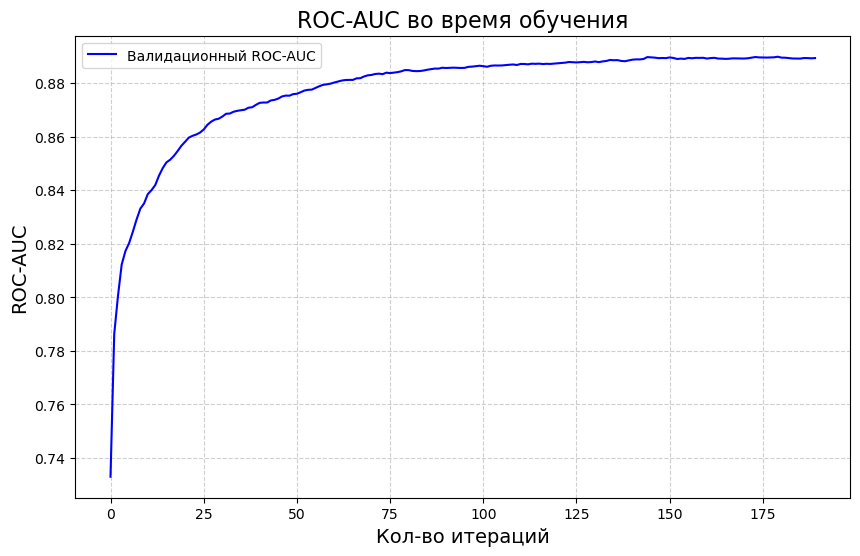

In [72]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Расчёт Accuracy на каждой итерации
predictions_proba = final_model.predict_proba(X_test)
threshold = 0.5  # Порог классификации
predictions_class = (predictions_proba[:, 1] > threshold).astype(int)
accuracy = accuracy_score(y_test, predictions_class)
rog_auc = roc_auc_score(y_test, predictions_class)

# Построение графика ROC-AUC
plt.figure(figsize=(10, 6))
plt.plot(iterations, roc_auc_history, label='Валидационный ROC-AUC', color='blue')
plt.title('ROC-AUC во время обучения', fontsize=16)
plt.xlabel('Кол-во итераций', fontsize=14)
plt.ylabel('ROC-AUC', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

А также численно покажем итоговые значения

In [73]:
print(f"ROC-AUC: {roc_auc}")
print(f"Accuracy: {accuracy}")

ROC-AUC: 0.8793100526576748
Accuracy: 0.8061587050927753


### Отображение важности признаков

Отобразим 3 графика:
1. Важность всех признаков
2. 15 признаков с наибольшей важностью
3. 15 признаков с наименьшей важностью

Отрисовка всех 3-х графиков упростит дальнейший анализ результатов

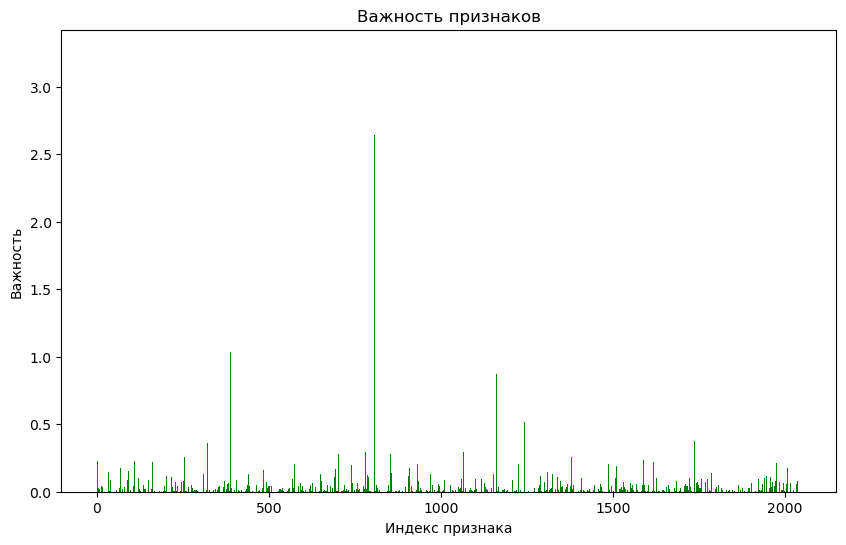

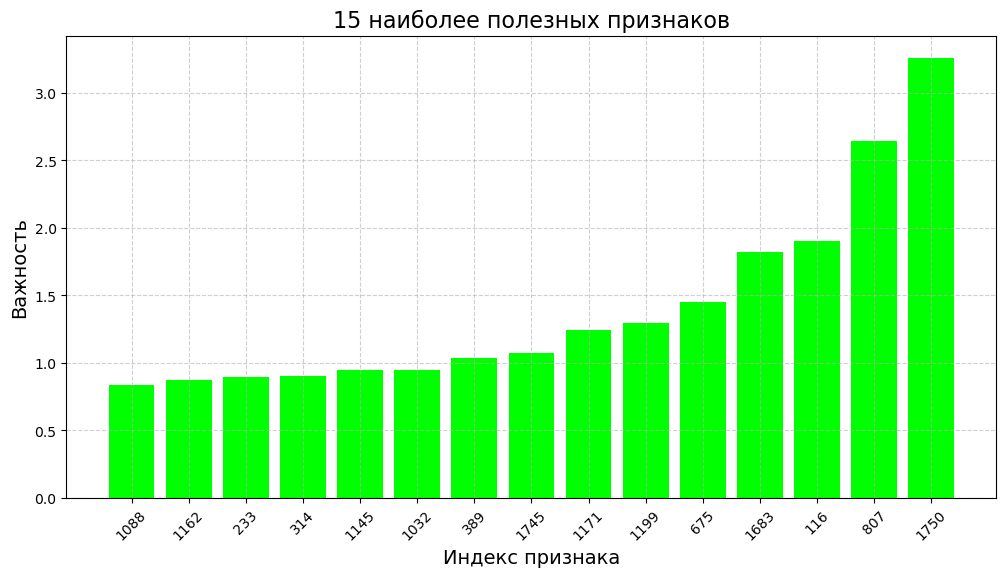

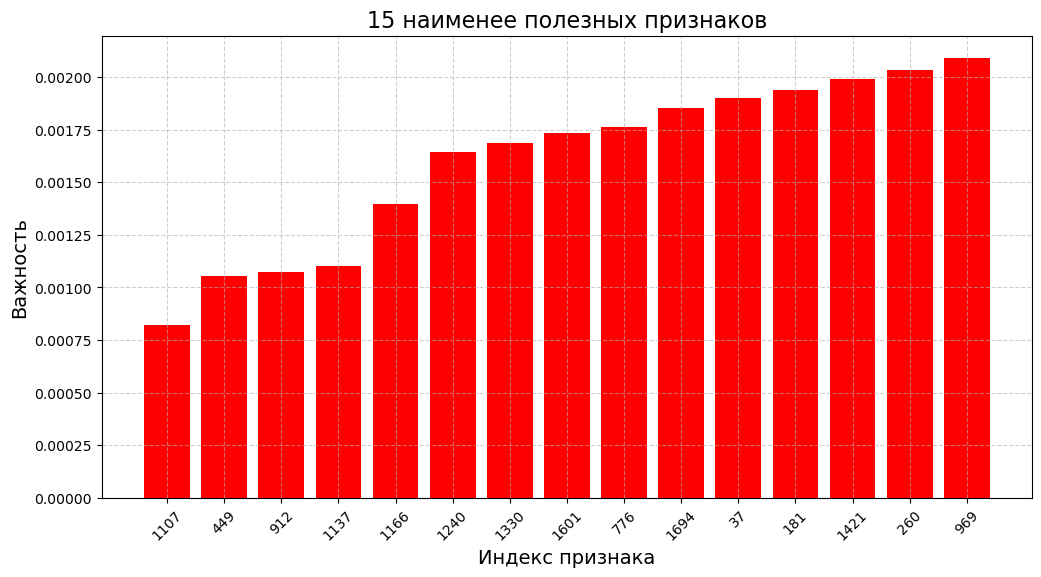

In [74]:
import matplotlib.pyplot as plt

plt.style.use('default')

feature_importances = final_model.get_feature_importance()

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances, color='green')
plt.title('Важность признаков')
plt.xlabel('Индекс признака')
plt.ylabel('Важность')
plt.show()

# Индексы признаков
feature_indices = np.arange(len(feature_importances))

nonzero_indices = np.where(feature_importances > 0)[0]
nonzero_importances = feature_importances[nonzero_indices]

sorted_indices = np.argsort(nonzero_importances)

# Для 15 самых значимых признаков
top_15_indices = nonzero_indices[sorted_indices[-15:]]  # Индексы 15 самых значимых признаков
top_15_importances = nonzero_importances[sorted_indices[-15:]]

plt.figure(figsize=(12, 6))
plt.bar(range(len(top_15_importances)), top_15_importances, color='lime')
plt.title('15 наиболее полезных признаков', fontsize=16)
plt.xlabel('Индекс признака', fontsize=14)
plt.ylabel('Важность', fontsize=14)
plt.xticks(range(len(top_15_importances)), top_15_indices, rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Для 15 наименее значимых признаков
bottom_15_indices = nonzero_indices[sorted_indices[:15]]  # Индексы 15 наименее значимых признаков
bottom_15_importances = nonzero_importances[sorted_indices[:15]]

plt.figure(figsize=(12, 6))
plt.bar(range(len(bottom_15_importances)), bottom_15_importances, color='red')
plt.title('15 наименее полезных признаков', fontsize=16)
plt.xlabel('Индекс признака', fontsize=14)
plt.ylabel('Важность', fontsize=14)
plt.xticks(range(len(bottom_15_importances)), bottom_15_indices, rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Выводы

### 1. Качество модели на тестовой выборке
- **ROC-AUC: 0.8793**
  - Достаточно высокая метрика, которая указывает, что модель хорошо различает классы.
  - Значение близко к 1, что говорит о том, что модель корректно оценивает вероятности классов.

**Вывод:**
Модель показывает хорошее качество на тестовой выборке. ROC-AUC лучше всего отражает способность модели различать классы, а Accuracy подтверждает, что большинство объектов классифицируются правильно.

---


## 2. Изменение ROC-AUC во время обучения
График ROC-AUC показывает стабильный рост метрики в первые 40-50 итераций, после чего она стабилизируется около значения 0.88–0.89. Это указывает на то, что модель не переобучается и достигает своей оптимальной производительности на валидационной выборке.

**Вывод:**
- Подбор гиперпараметров и количество итераций выбраны корректно.
- Ранняя остановка на основании метрики AUC могла бы дополнительно сократить время обучения.

---

## 3. Важность признаков
- **График важности признаков (общий):**
  - Среди признаков многие имеют низкую значимость, что может быть связано с шумовыми данными, недостаточной их информативностью или тем, что некоторые аспекты молекулярной формулы не влияют на классификацию.
  - Небольшое количество признаков (около 15-20) имеют значительную важность.

- **Топ-15 самых значимых признаков:**
  - Важность значимых признаков варьируется от 1 до 3.
  - Большинство значимых признаков имеют близкие значения важности, что указывает на их схожий вклад в модель.

- **Топ-15 наименее значимых признаков:**
  - Эти признаки имеют крайне низкую значимость, близкую к нулю, что свидетельствует о том, что они практически не влияют на предсказания модели.

**Вывод:**
- Удаление наименее значимых признаков (например, с важностью = 0 или близкой к 0) может ускорить обучение модели и уменьшить её сложность без потери качества.

---

## 4. Общий вывод по заданию
- **Модель CatBoost** успешно справилась с задачей классификации на основе признаков SMILES.
- **$ROC-AUC = 0.8793$** подтверждает высокое качество предсказаний модели.
- **$Accuracy = 0.8061$** также показывает, что большинство объектов классифицируются правильно.
- **Анализ важности признаков** выявил, что модель полагается на небольшой поднабор признаков, что может быть полезным для дальнейшей оптимизации (например, удаления незначимых признаков).

---